# **Predicting Flight Delays**
*Anuneet Anand [2018022]*

*Mohnish Agrawal [2018053]*

*Rhythm Patel [2018083]*

### **Importing Libraries & Uploading Datasets**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install sweetviz
import datetime
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from math import sin,cos,pi
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier
from matplotlib.colors import LinearSegmentedColormap
import tensorflow.compat.v2 as tf
%matplotlib inline
plt.style.use('seaborn')

In [ ]:
Airlines = pd.read_csv('/content/gdrive/My Drive/ML_Project/airlines.csv')
Airports = pd.read_csv('/content/gdrive/My Drive/ML_Project/airports.csv')
Flights = pd.read_csv('/content/gdrive/My Drive/ML_Project/flights.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### **Dataset Overview**

***Dataset Descriptions***

In [ ]:
print(Flights.info(verbose = True, null_counts=True))
print(Airlines.info(verbose = True, null_counts=True))
print(Airports.info(verbose = True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

***Cancellation Reasons***

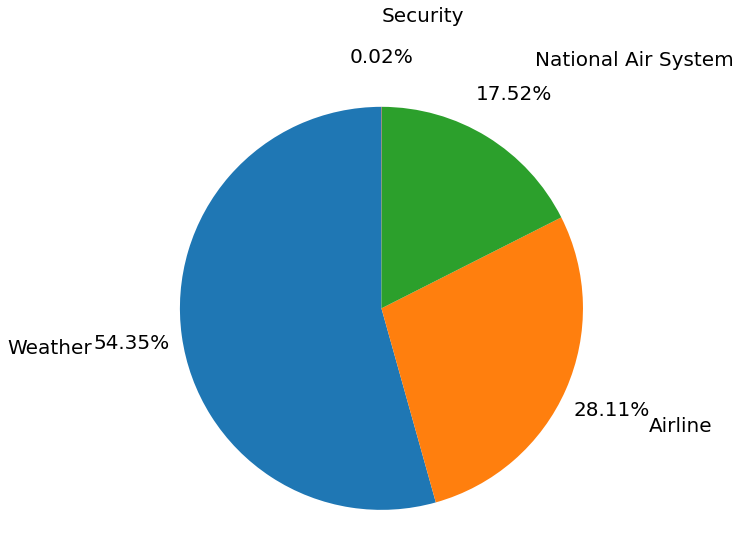

In [ ]:
cancelled = Flights['CANCELLATION_REASON']
cancelled.dropna(inplace=True)
cancelledCount = dict(cancelled.value_counts())
labels = ['Weather','Airline','National Air System','Security']
sizes = cancelledCount.values()

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, labels=labels, pctdistance=1.25, labeldistance=1.45, autopct='%1.2f%%', startangle=90, textprops={'fontsize': 20})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

***Flights on Different Days of Week***

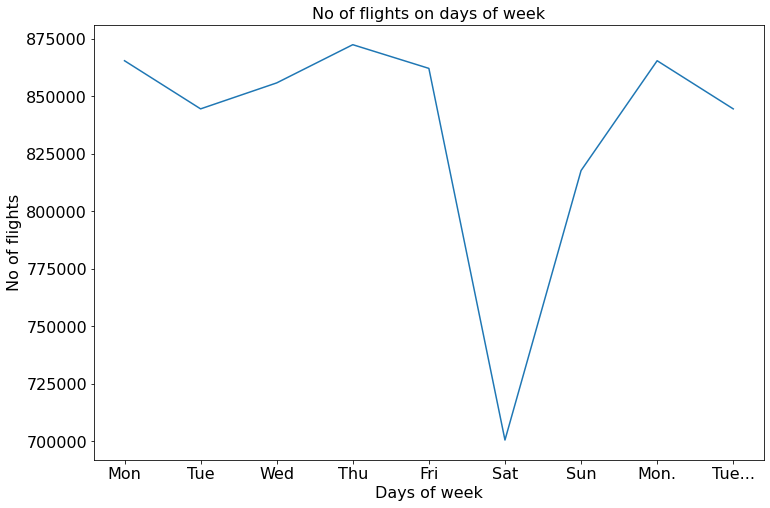

In [ ]:
daysOfWeek = Flights['DAY_OF_WEEK']
dayCounts = dict(daysOfWeek.value_counts())
dayFreq = {}
for day in sorted(dayCounts):
    dayFreq[day] = dayCounts[day]

plt.figure(figsize=(12,8))
flightFreq = list(dayFreq.values())
flightFreq.append(dayFreq[1]) # add monday
flightFreq.append(dayFreq[2]) # add tuesday
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Mon.','Tue...']
plt.plot(days,flightFreq)
plt.xlabel("Days of week", fontsize=16)
plt.ylabel("No of flights", fontsize=16)
plt.title("No of flights on days of week", fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

***Flights in Different Months***

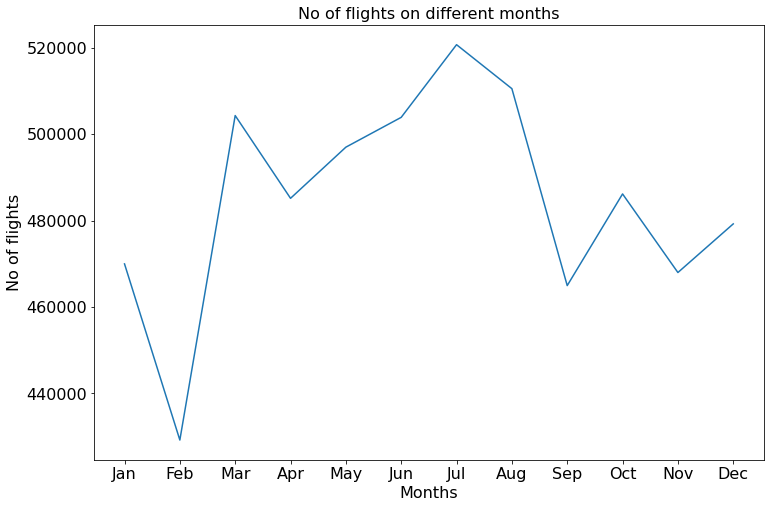

In [ ]:
months = Flights['MONTH']
monthCounts = dict(months.value_counts())
monthFreq = {}
for month in sorted(monthCounts):
    monthFreq[month] = monthCounts[month]

plt.figure(figsize=(12,8))
flightFreq = list(monthFreq.values())
monthsArr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(monthsArr, flightFreq)
plt.xlabel("Months", fontsize=16)
plt.ylabel("No of flights", fontsize=16)
plt.title("No of flights on different months", fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

***Delay Threshold***

In [ ]:
ttl = Flights.shape[0]
threshold = 3
delayLessThanThreshold = Flights[Flights['ARRIVAL_DELAY'] <= threshold].shape[0] / ttl
delayLessThanThreshold

0.6780059181186576

### **Cleaning Datasets**

***Dropping rows with NaN values and selecting data for January***

In [ ]:
Flights = Flights.iloc[:,:23]
Flights.dropna(inplace=True)
Flights = Flights[Flights["MONTH"]==1]
Flights.reset_index(inplace=True)

***Formatting Time***

In [ ]:
def Time_Formatx(x):
  if x == 2400:
    x = 0
  x = "{0:04d}".format(int(x))
  T = datetime.time(int(x[0:2]), int(x[2:4]))
  return T

***Collecting Names of Airlines and Airports***

In [ ]:
Airline_Names = {}
for i in range(len(Airlines)):
  Airline_Names[Airlines["IATA_CODE"][i]]=Airlines["AIRLINE"][i]

Airport_Names = {}
for i in range(len(Airports)):
  Airport_Names[Airports["IATA_CODE"][i]]=Airports["AIRPORT"][i]

City_Names = {}
for i in range(len(Airports)):
  City_Names[Airports["IATA_CODE"][i]]=Airports["CITY"][i]

***Merging Datasets & Selecting relevant columns***

In [ ]:
df = pd.DataFrame()
df['DATE'] = pd.to_datetime(Flights[['YEAR','MONTH', 'DAY']])
df['DAY'] = Flights["DAY_OF_WEEK"]
df['AIRLINE'] = Flights["AIRLINE"]
df['AIRLINE_NAME'] = [Airline_Names[Flights["AIRLINE"][x]] for x in range(len(Flights))]
df['FLIGHT_NUMBER'] = Flights['FLIGHT_NUMBER']
df['TAIL_NUMBER'] = Flights['TAIL_NUMBER']
df['ORIGIN'] = Flights['ORIGIN_AIRPORT']
df['ORIGIN_AIRPORT_NAME'] = [Airport_Names[Flights["ORIGIN_AIRPORT"][x]] for x in range(len(Flights))]
df['ORIGIN_CITY'] = [City_Names[Flights["ORIGIN_AIRPORT"][x]] for x in range(len(Flights))]
df['DESTINATION'] = Flights['DESTINATION_AIRPORT']
df['DESTINATION_AIRPORT_NAME'] = [Airport_Names[Flights["DESTINATION_AIRPORT"][x]] for x in range(len(Flights))]
df['DESTINATION_CITY'] = [City_Names[Flights["DESTINATION_AIRPORT"][x]] for x in range(len(Flights))]
df['DISTANCE'] = Flights['DISTANCE']
df['SCHEDULED_DEPARTURE'] = Flights['SCHEDULED_DEPARTURE'].apply(Time_Formatx)
df['SCHEDULED_ARRIVAL'] = Flights['SCHEDULED_ARRIVAL'].apply(Time_Formatx)
df['TAXI_OUT'] = Flights['TAXI_OUT']
df['DEPARTURE_DELAY'] = Flights['DEPARTURE_DELAY']
df['ARRIVAL_DELAY'] = Flights['ARRIVAL_DELAY']
df = df[df.ARRIVAL_DELAY < 500]
df

,DATE,DAY,AIRLINE,AIRLINE_NAME,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN,ORIGIN_AIRPORT_NAME,ORIGIN_CITY,DESTINATION,DESTINATION_AIRPORT_NAME,DESTINATION_CITY,DISTANCE,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,TAXI_OUT,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,SEA,Seattle-Tacoma International Airport,Seattle,1448,00:05:00,04:30:00,21.0,-11.0,-22.0
1,2015-01-01,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,PBI,Palm Beach International Airport,West Palm Beach,2330,00:10:00,07:50:00,12.0,-8.0,-9.0
2,2015-01-01,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CLT,Charlotte Douglas International Airport,Charlotte,2296,00:20:00,08:06:00,16.0,-2.0,5.0
3,2015-01-01,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,MIA,Miami International Airport,Miami,2342,00:20:00,08:05:00,15.0,-5.0,-9.0
4,2015-01-01,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,ANC,Ted Stevens Anchorage International Airport,Anchorage,1448,00:25:00,03:20:00,11.0,-1.0,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457008,2015-01-31,6,B6,JetBlue Airways,839,N658JB,JFK,John F. Kennedy International Airport (New Yor...,New York,BQN,Rafael Hernández Airport,Aguadilla,1576,23:59:00,04:40:00,18.0,0.0,-21.0
457009,2015-01-31,6,DL,Delta Air Lines Inc.,1887,N855NW,SEA,Seattle-Tacoma International Airport,Seattle,DTW,Detroit Metropolitan Airport,Detroit,1927,23:59:00,07:11:00,16.0,0.0,-13.0
457010,2015-01-31,6,F9,Frontier Airlines Inc.,300,N218FR,DEN,Denver International Airport,Denver,TPA,Tampa International Airport,Tampa,1506,23:59:00,05:11:00,35.0,3.0,23.0
457011,2015-01-31,6,F9,Frontier Airlines Inc.,422,N954FR,DEN,Denver International Airport,Denver,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,1199,23:59:00,04:41:00,40.0,0.0,29.0


### **Exploratory Data Analysis**

In [ ]:
report = sv.analyze(df)
report.show_html("EDA.html")

***Statistical Information for a Group***

In [ ]:
def stats(g):
  return {'mean':g.mean(), 'variance':g.var(), 'count':g.count(), 'min':g.min(), 'max':g.max()}

***Air Traffic Share of Airlines***

In [ ]:
plt.subplots(figsize=(15,20))
plt.pie(df['AIRLINE'].value_counts(),labels=df['AIRLINE_NAME'].unique(),autopct='%1.0f%%',textprops={'fontsize': 20})
plt.show()

***Calculating Data Statistics***

In [ ]:
Origin_Stats = df['ARRIVAL_DELAY'].groupby(df['ORIGIN']).apply(stats).unstack().sort_values('count',ascending=False)
Destination_Stats = df['ARRIVAL_DELAY'].groupby(df['DESTINATION']).apply(stats).unstack().sort_values('count',ascending=False)
Airline_Stats = df['ARRIVAL_DELAY'].groupby(df['AIRLINE']).apply(stats).unstack().sort_values('mean')

Airline_Stats

***Airline Delays on Different Days of Week***

In [ ]:
Days = ["Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
Airline_Day_Stats = pd.DataFrame()
for a in df['AIRLINE'].unique():
  x = df[df['AIRLINE']==a]
  t = x['ARRIVAL_DELAY'].groupby(df['DAY']).mean()
  Airline_Day_Stats[a]=t
Airline_Day_Stats.dropna(inplace=True)
Airline_Day_Stats

In [ ]:
sns.set(context="paper")
plt.subplots(figsize=(10,8))
plt.title("Mean Delay for Airline Vs. Day of Week")
sns.heatmap(Airline_Day_Stats, linewidths=0.01, cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256),robust=True,yticklabels=Days)
plt.show()

***Busiest airports and Airlines***

In [ ]:
Airports = df['DESTINATION_CITY'].groupby(df["DESTINATION_CITY"]).count().sort_values(ascending=False).iloc[:11].keys().tolist()
map = df[['AIRLINE_NAME','DESTINATION_CITY','ARRIVAL_DELAY']]

frames = list()
for x in Airports:
  frames.append(map.loc[map["DESTINATION_CITY"] == x])
map = pd.concat(frames)

airline_city_delay = pd.DataFrame()
for airlines in map["AIRLINE_NAME"].unique():
  t = map.loc[map["AIRLINE_NAME"] == airlines]
  temp = t["ARRIVAL_DELAY"].groupby(t["DESTINATION_CITY"]).mean()
  airline_city_delay[airlines] = temp


In [ ]:
sns.set(context="paper")
plt.subplots(figsize=(10,8))
plt.title("Mean Delay for Airline Vs. Destination Airports")
sns.heatmap(airline_city_delay, linewidths=0.01, cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256),robust=True,yticklabels=Airports)
plt.show()

**Distance and Delay**

In [ ]:
map = df[["DISTANCE","ARRIVAL_DELAY","AIRLINE_NAME"]].copy()
interval = list()
for i in range(0,5000,100):
  interval.append(i)

map["DISTANCE_INTERVAL"] = pd.cut(x = map["DISTANCE"], bins = interval)
map["DISTANCE_MID"] = map["DISTANCE_INTERVAL"].apply(lambda x : x.mid)
newMap = map["ARRIVAL_DELAY"].groupby(map["DISTANCE_MID"]).mean().to_frame()
newMap.dropna(inplace=True)
newMap.plot.line(title = "Distance vs Delay graph (Bucket Size:100)")
plt.show()

***Distribution of Arrival Delay***

In [ ]:
sns.displot(df['ARRIVAL_DELAY'], bins = [i for i in range(-50,100)])
plt.show()

### **Pre-Processing**

***Selecting Features***

In [ ]:
Data = df[['ARRIVAL_DELAY','ORIGIN','DESTINATION','DISTANCE','TAXI_OUT','DEPARTURE_DELAY','DATE','DAY','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL']].copy()


***Handling Date and Time Data***

In [ ]:
SD = Data['SCHEDULED_DEPARTURE']
SA = Data['SCHEDULED_ARRIVAL']
DA = Data['DATE']

Data['SDH_Sin'] = [sin(2*pi*d.hour/24) for d in SD]
Data['SDH_Cos'] = [cos(2*pi*d.hour/24) for d in SD]
Data['SDM_Sin'] = [sin(2*pi*d.minute/60) for d in SD]
Data['SDM_Cos'] = [cos(2*pi*d.minute/60) for d in SD]

Data['SAH_Sin'] = [sin(2*pi*d.hour/24) for d in SA]
Data['SAH_Cos'] = [cos(2*pi*d.hour/24) for d in SA]
Data['SAM_Sin'] = [sin(2*pi*d.minute/60) for d in SA]
Data['SAM_Cos'] = [cos(2*pi*d.minute/60) for d in SA]

Data['DAM_Sin'] = [sin(2*pi*d.month/12) for d in DA]
Data['DAM_Cos'] = [cos(2*pi*d.month/12) for d in DA]
Data['DAD_Sin'] = [sin(2*pi*d.day/31) for d in DA]
Data['DAD_Cos'] = [cos(2*pi*d.day/31) for d in DA]

Data = Data.drop(['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DATE'],axis=1)
Data.dropna(inplace=True)
Data.reset_index(inplace=True,drop=True)
Data

,ARRIVAL_DELAY,ORIGIN,DESTINATION,DISTANCE,TAXI_OUT,DEPARTURE_DELAY,DAY,AIRLINE,SDH_Sin,SDH_Cos,SDM_Sin,SDM_Cos,SAH_Sin,SAH_Cos,SAM_Sin,SAM_Cos,DAM_Sin,DAM_Cos,DAD_Sin,DAD_Cos
0,-22.0,ANC,SEA,1448,21.0,-11.0,4,AS,0.000000,1.000000,0.500000,0.866025,0.866025,0.500000,5.665539e-16,-1.000000,0.5,0.866025,2.012985e-01,0.97953
1,-9.0,LAX,PBI,2330,12.0,-8.0,4,AA,0.000000,1.000000,0.866025,0.500000,0.965926,-0.258819,-8.660254e-01,0.500000,0.5,0.866025,2.012985e-01,0.97953
2,5.0,SFO,CLT,2296,16.0,-2.0,4,US,0.000000,1.000000,0.866025,-0.500000,0.866025,-0.500000,5.877853e-01,0.809017,0.5,0.866025,2.012985e-01,0.97953
3,-9.0,LAX,MIA,2342,15.0,-5.0,4,AA,0.000000,1.000000,0.866025,-0.500000,0.866025,-0.500000,5.000000e-01,0.866025,0.5,0.866025,2.012985e-01,0.97953
4,-21.0,SEA,ANC,1448,11.0,-1.0,4,AS,0.000000,1.000000,0.500000,-0.866025,0.707107,0.707107,8.660254e-01,-0.500000,0.5,0.866025,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456850,-21.0,JFK,BQN,1576,18.0,0.0,6,B6,-0.258819,0.965926,-0.104528,0.994522,0.866025,0.500000,-8.660254e-01,-0.500000,0.5,0.866025,-2.449294e-16,1.00000
456851,-13.0,SEA,DTW,1927,16.0,0.0,6,DL,-0.258819,0.965926,-0.104528,0.994522,0.965926,-0.258819,9.135455e-01,0.406737,0.5,0.866025,-2.449294e-16,1.00000
456852,23.0,DEN,TPA,1506,35.0,3.0,6,F9,-0.258819,0.965926,-0.104528,0.994522,0.965926,0.258819,9.135455e-01,0.406737,0.5,0.866025,-2.449294e-16,1.00000
456853,29.0,DEN,ATL,1199,40.0,0.0,6,F9,-0.258819,0.965926,-0.104528,0.994522,0.866025,0.500000,-9.135455e-01,-0.406737,0.5,0.866025,-2.449294e-16,1.00000


***Handling Categorical Variables***

In [ ]:

L = LabelEncoder()

Data['AIRLINE']=L.fit_transform(np.array(Data['AIRLINE']).reshape(-1,1))
Data['ORIGIN']=L.fit_transform(np.array(Data['ORIGIN']).reshape(-1,1))
Data['DESTINATION']=L.fit_transform(np.array(Data['DESTINATION']).reshape(-1,1))

H = OneHotEncoder()

a = pd.DataFrame(H.fit_transform(np.array(Data['AIRLINE']).reshape(-1,1)).toarray())
a.columns = [str(i) for i in range(len(a.columns))]
b = pd.DataFrame(H.fit_transform(np.array(Data['ORIGIN']).reshape(-1,1)).toarray())
b.columns = [str(i+len(a.columns)) for i in range(len(b.columns))]
c = pd.DataFrame(H.fit_transform(np.array(Data['DESTINATION']).reshape(-1,1)).toarray())
c.columns = [str(i+len(a.columns)+len(b.columns)) for i in range(len(c.columns))]

Data = Data.drop(['AIRLINE'],axis=1)
Data = Data.join(a)
#Data = Data.drop(['ORIGIN'],axis=1)
#Data = Data.join(b)
#Data = Data.drop(['DESTINATION'],axis=1)
#Data = Data.join(c)
Data.dropna(inplace=True)
Data

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ARRIVAL_DELAY,ORIGIN,DESTINATION,DISTANCE,TAXI_OUT,DEPARTURE_DELAY,DAY,SDH_Sin,SDH_Cos,SDM_Sin,SDM_Cos,SAH_Sin,SAH_Cos,SAM_Sin,SAM_Cos,DAM_Sin,DAM_Cos,DAD_Sin,DAD_Cos,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-22.0,15,268,1448,21.0,-11.0,4,0.000000,1.000000,0.500000,0.866025,0.866025,0.500000,5.665539e-16,-1.000000,0.5,0.866025,2.012985e-01,0.97953,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9.0,168,226,2330,12.0,-8.0,4,0.000000,1.000000,0.866025,0.500000,0.965926,-0.258819,-8.660254e-01,0.500000,0.5,0.866025,2.012985e-01,0.97953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,269,62,2296,16.0,-2.0,4,0.000000,1.000000,0.866025,-0.500000,0.866025,-0.500000,5.877853e-01,0.809017,0.5,0.866025,2.012985e-01,0.97953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-9.0,168,195,2342,15.0,-5.0,4,0.000000,1.000000,0.866025,-0.500000,0.866025,-0.500000,5.000000e-01,0.866025,0.5,0.866025,2.012985e-01,0.97953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-21.0,268,15,1448,11.0,-1.0,4,0.000000,1.000000,0.500000,-0.866025,0.707107,0.707107,8.660254e-01,-0.500000,0.5,0.866025,2.012985e-01,0.97953,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456850,-21.0,158,38,1576,18.0,0.0,6,-0.258819,0.965926,-0.104528,0.994522,0.866025,0.500000,-8.660254e-01,-0.500000,0.5,0.866025,-2.449294e-16,1.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456851,-13.0,268,88,1927,16.0,0.0,6,-0.258819,0.965926,-0.104528,0.994522,0.965926,-0.258819,9.135455e-01,0.406737,0.5,0.866025,-2.449294e-16,1.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456852,23.0,81,294,1506,35.0,3.0,6,-0.258819,0.965926,-0.104528,0.994522,0.965926,0.258819,9.135455e-01,0.406737,0.5,0.866025,-2.449294e-16,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456853,29.0,81,18,1199,40.0,0.0,6,-0.258819,0.965926,-0.104528,0.994522,0.866025,0.500000,-9.135455e-01,-0.406737,0.5,0.866025,-2.449294e-16,1.00000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Splitting into X and Y***

In [ ]:
X = Data.copy()
X.drop(['ARRIVAL_DELAY'],axis=1, inplace = True)
Y = Data['ARRIVAL_DELAY'].copy()

for i in range(len(Y)):
    if Y[i]<3: Y[i]=0
    else: Y[i]=1

X = X.to_numpy()
Y = Y.to_numpy()
print(X.shape)
print(Y.shape)

(456855, 32)
(456855,)


***Splitting into Train, Val, Test***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0, stratify = Y)
X_val, X_test, y_val, y_test = train_test_split( X_test, y_test, test_size=0.66, random_state=0, stratify = y_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(319798, 32) (46599, 32) (90458, 32)
(319798,) (46599,) (90458,)


***Standard Scaling***

In [ ]:
s = StandardScaler()
s.fit(X_train)
X_train = s.transform(X_train)
X_val = s.transform(X_val)
X_test = s.transform(X_test)

### **Training Models**

***Logistic Regression***

In [ ]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
y_pred = logistic.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
score = logistic.score(X_test,y_test)
print(score)

sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion Matrix", size = 15);
plt.show()

***SGD Classifier***

0.8639368546728868


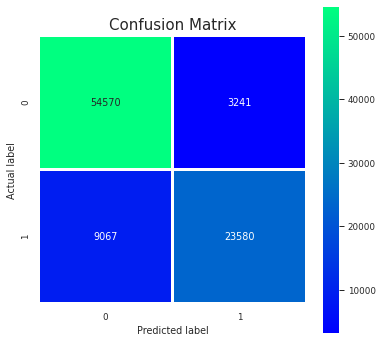

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
score = sgd.score(X_test,y_test)
print(score)

sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion Matrix", size = 15);
plt.show()

***Support Vector Machines***

0.8595480775608569


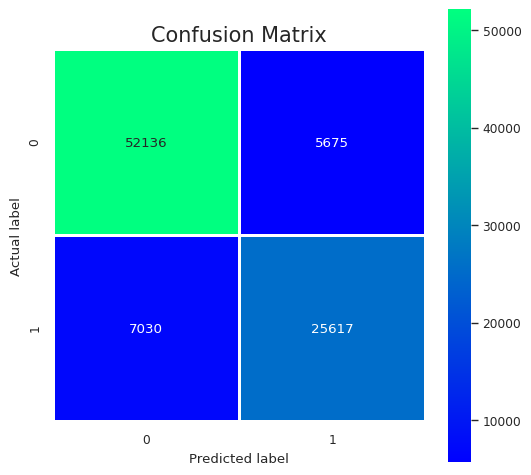

In [ ]:
svc = BalancedBaggingClassifier(svm.LinearSVC(), n_jobs=-1)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
score = svc.score(X_test,y_test)
print(score)

sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion Matrix", size = 15);
plt.show()

***Neural Networks***

In [ ]:
# train = np.hstack((X_train, y_train[:, np.newaxis]))
# val = np.hstack((X_val, y_val[:, np.newaxis]))
# test = np.hstack((X_test, y_test[:, np.newaxis]))

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(128,activation='relu'),
#   tf.keras.layers.Dense(2, activation='softmax')
# ])

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     metrics=['accuracy'],
# )

# model.fit(
#     train,
#     epochs=6,
# )

### **Finding Optimal Hyperparameters**


In [ ]:
'''
Enter the parameter and it's possible types here 
If max_depth = 10,100,1000 and loss = L1,L2
The code will run 3*2 times.
For plotting the graph, please keep only 2 sets of parameters as it's a 2D graph.
Otherwise one would have to split the array and it will lead to confusion.
'''
# # Logistic Regression
parameters = {
    'penalty': ['l2'],
    'fit_intercept': [True, False],
    'max_iter': [2,4,6,8,10],
    'n_jobs': [-1]}

clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=3)
clf.fit(X_train,y_train)
print("Best Score:", clf.best_score_)
print("Best Parameters:", clf.best_params_)

bestEstimator = clf.best_estimator_
y_pred = bestEstimator.predict(X_test)
score = bestEstimator.score(X_test,y_test)
print("Test Score:", score)

Best Score: 0.8633043348717683
Best Parameters: {'fit_intercept': True, 'max_iter': 10, 'n_jobs': -1, 'penalty': 'l2'}
Test Score: 0.8641579517566164


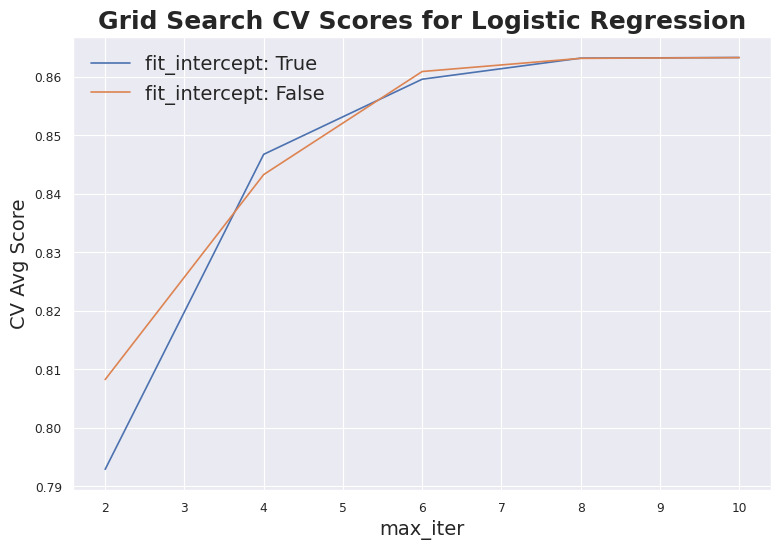

In [ ]:
# Plotting the parameters

param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
param_color_name = 'fit_intercept' # parameter that you want as the different colored curves

param_xAxis = parameters[param_xAxis_name]
param_color = parameters[param_color_name]

mean_test_score = clf.cv_results_['mean_test_score']
mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

_, ax = plt.subplots(1,1, figsize=(9,6))

for i in range(len(param_color)):
    ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

ax.set_title("Grid Search CV Scores for Logistic Regression", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)
ax.legend(fontsize=14)
plt.show()

In [ ]:
# # SGDClassifier
parameters = {
    'penalty': ['l1','l2'],
    'max_iter': [50, 100, 250, 500, 1000, 2500, 5000, 7500, 10000],
    'n_jobs': [-1]}

clf = GridSearchCV(SGDClassifier(), parameters, n_jobs=-1, cv=4)
clf.fit(X_train,y_train)
print("Best Score:", clf.best_score_)
print("Best Parameters:", clf.best_params_)

bestEstimator = clf.best_estimator_
y_pred = bestEstimator.predict(X_test)
score = bestEstimator.score(X_test,y_test)
print("Test Score:", score)

Best Score: 0.8624412900622521
Best Parameters: {'max_iter': 100, 'n_jobs': -1, 'penalty': 'l1'}
Test Score: 0.8635830993389197


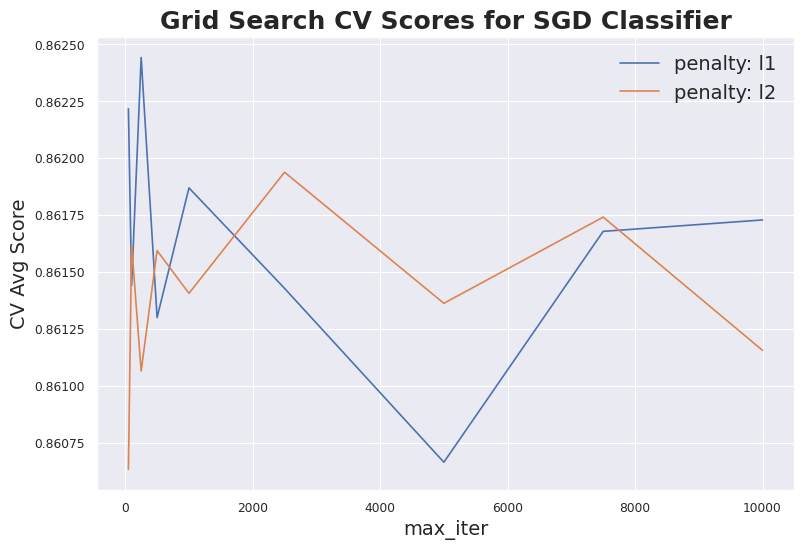

In [ ]:
# Plotting the parameters

param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
param_color_name = 'penalty' # parameter that you want as the different colored curves

param_xAxis = parameters[param_xAxis_name]
param_color = parameters[param_color_name]

mean_test_score = clf.cv_results_['mean_test_score']
mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

_, ax = plt.subplots(1,1, figsize=(9,6))

for i in range(len(param_color)):
    ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

ax.set_title("Grid Search CV Scores for SGD Classifier", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)
ax.legend(fontsize=14)
plt.show()

In [ ]:
# # SVC
parameters = {
    'penalty': ['l1','l2'],
    'max_iter': [50, 100, 250, 500, 1000, 2500, 5000, 7500, 10000]}

clf = GridSearchCV(svm.LinearSVC(), parameters, n_jobs=-1, cv=4)
clf.fit(X_train,y_train)
print("Best Score:", clf.best_score_)
print("Best Parameters:", clf.best_params_)

bestEstimator = clf.best_estimator_
y_pred = bestEstimator.predict(X_test)
score = bestEstimator.score(X_test,y_test)
print("Test Score:", score)

In [ ]:
# Plotting the parameters

param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
param_color_name = 'penalty' # parameter that you want as the different colored curves

param_xAxis = parameters[param_xAxis_name]
param_color = parameters[param_color_name]

mean_test_score = clf.cv_results_['mean_test_score']
mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

_, ax = plt.subplots(1,1, figsize=(9,6))

for i in range(len(param_color)):
    ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

ax.set_title("Grid Search CV Scores for SVC", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)
ax.legend(fontsize=14)
plt.show()

Random forest 


In [ ]:
parametersrf = {
    'criterion': ["gini", "entropy"],
    'class_weight': [None, "balanced"],
    'n_estimators': [200,400,600]
    }

clfrf = GridSearchCV(RandomForestClassifier(), parametersrf, n_jobs=-1, cv=3)
clfrf.fit(X_train,y_train)
print("Best Score:", clfrf.best_score_)
print("Best Parameters:", clfrf.best_params_)
bestEstimatorrf = clfrf.best_estimator_

y_pred = bestEstimatorrf.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
score = bestEstimatorrf.score(X_test,y_test)
print(score)

Plotting hyper params


In [ ]:
param_xAxis_name = 'n_estimators' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
param_color_name = 'criterion' # parameter that you want as the different colored curves

param_xAxis = parametersrf[param_xAxis_name]
param_color = parametersrf[param_color_name]
param_label = parameters["class_weight"]
mean_test_score = clfrf.cv_results_['mean_test_score']
mean_test_score_none = mean_test_score[:len(mean_test_score)//2]
mean_test_score_bal = mean_test_score[len(mean_test_score)//2:]
mean_test_score_none = np.array(mean_test_score_none).reshape(len(param_color), len(param_xAxis))
mean_test_score_bal = np.array(mean_test_score_bal).reshape(len(param_color), len(param_xAxis))


_, ax = plt.subplots(1,1, figsize=(9,6))

for i in range(len(param_color)):
    ax.plot(param_xAxis, mean_test_score_none[i,:], label=param_color_name+': ' + str(param_color[i]) + ", class weight:" + str(param_label[i]))
    ax.plot(param_xAxis, mean_test_score_bal[i,:], label=param_color_name+': ' + str(param_color[i]) + ", class weight:" + str(param_label[i]))

ax.set_title("Grid Search CV Scores for Random Forest Classifier", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)
ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), title = "Criterion, class weight")
plt.setp(legend.get_title(),fontsize='x-large')
plt.show()

Gaussian Naive Bayes

In [ ]:
parametersnb = {
    "var_smoothing": [10**-20,10**-11,10**-9, 10**-7, 10**-5, 10**-2]
    }

clfnb = GridSearchCV(GaussianNB(), parameters, n_jobs=-1, cv=3)
clfnb.fit(X_train,y_train)
print("Best Score:", clfnb.best_score_)
print("Best Parameters:", clfnb.best_params_)
bestEstimatornb = clfnb.best_estimator_
y_pred = bestEstimatornb.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(confusionMatrix)
scorenb = bestEstimatornb.score(X_test,y_test)
print(scorenb)

Plotting hyperparameters

In [ ]:
param_xAxis_name = 'var_smoothing' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)

param_xAxis = parameters[param_xAxis_name]
param_label = parameters[param_xAxis_name]
print(clfnb.cv_results_["params"])
mean_test_score = clfnb.cv_results_['mean_test_score']

_, ax = plt.subplots(1,1, figsize=(9,6))

ax.plot(param_xAxis, mean_test_score)
ax.set_title("Grid Search CV Scores for Gaussian naive bayes", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)

plt.show()

XGB Classifier


In [ ]:
parameters = {
    'max_depth':[5,7,15],
    'learning_rate': [0.01,0.001,0.1],
    'class_weight': [None, "balanced"],
    'n_estimators': [100,200,300]
    }

clf = GridSearchCV(XGBClassifier(), parameters, n_jobs=-1, cv=3)
clf.fit(X_train,y_train)
print("Best Score:", clf.best_score_)
print("Best Parameters:", clf.best_params_)
bestEstimator = clf.best_estimator_
y_pred = bestEstimator.predict(X_test)

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
score = bestEstimator.score(X_test,y_test)
print(score)

Plotting hyper-parameter

In [ ]:
# Plotting the parameters

param_xAxis_name = 'n_estimators' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
param_color_name = 'max_depth' # parameter that you want as the different colored curves

param_xAxis = parameters[param_xAxis_name]
param_color = parameters[param_color_name]
param_breaks = clf.cv_results_["params"]
mean_score = clf.cv_results_["mean_test_score"]
scores_list = [[] for i in range(6)]
j, k = len(param_xAxis)*len(param_color), 0
labels = dict()
for i in param_breaks:
    scores_list[k//j].append(mean_score[k]) 
    labels["learning_rate:"+str(clf.cv_results_["params"][k]["learning_rate"]) + ", class_weight:"+str(clf.cv_results_["params"][k]["class_weight"])] = k//j
    k += 1

labels = {v: k for k, v in labels.items()}
mean_test_score = np.array(scores_list).reshape(len(scores_list), len(param_color), len(param_xAxis))

_, ax = plt.subplots(1,1, figsize=(9,6))

for i in range(len(param_color)):
    for j in range(len(mean_test_score)):
        ax.plot(param_xAxis, mean_test_score[j,i,:], label=param_color_name+': ' + str(param_color[i]) + "," + labels[j])
    

ax.set_title("Grid Search CV Scores for XGB Classifier", fontsize=18, fontweight='bold')
ax.set_xlabel(param_xAxis_name, fontsize=14)
ax.set_ylabel('CV Avg Score', fontsize=14)
ax.legend(fontsize=14,  bbox_to_anchor=(1, 1.1), title = "max depth, learning rate, class weight")
plt.setp(legend.get_title(),fontsize='x-large')
plt.show()

###**ROC - AUC curve**

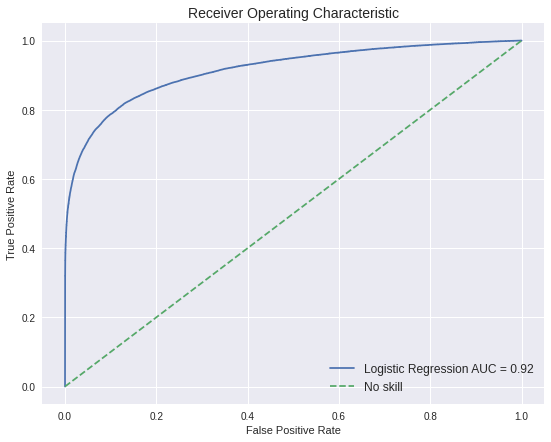

In [ ]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
y_pred_logistic = logistic.predict_proba(X_test)

fpr_logistic, tpr_logistic, threshold_logistic = metrics.roc_curve(y_test, y_pred_logistic[:, 1])
roc_auc = metrics.auc(fpr_logistic, tpr_logistic)

plt.subplots(figsize=(9,7))
plt.title("Receiver Operating Characteristic", fontsize=14)
plt.plot(fpr, tpr, label = "Logistic Regression AUC = %0.2f"%roc_auc)
plt.plot([0,1], [0,1], "--", label="No skill")
plt.legend(loc = "lower right", prop={'size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show()

***Getting the scores***

In [ ]:
# scoresXGB = bestEstimator.predict_proba(X_test)
# fprXGB, tprXGB, thresholdsXGB = metrics.roc_curve(y_test,scoresXGB[:,1])

# scoresRf = bestEstimatorrf.predict_proba(X_test)
# fprRf, tprRf, thresholdsRf = metrics.roc_curve(y_test,scoresRf[:,1])

# scoresnb = bestEstimatornb.predict_proba(X_test)
# fprnb, tprnb, thresholdsnb = metrics.roc_curve(y_test,scoresnb[:,1])

# roc_aucnb = metrics.auc(fprnb, tprnb)

logistic = LogisticRegression()
logistic.fit(X_train,y_train)
scoresLog = logistic.predict_proba(X_test)
fprLog, tprLog, thresholdsLog = metrics.roc_curve(y_test,scoresLog[:,1])

#AUC 
roc_auc = metrics.auc(fprLog, tprLog)
# roc_aucRf = metrics.auc(fprRf, tprRf)
# roc_aucXGB = metrics.auc(fprXGB, tprXGB)

***Plotting the curves***


Text(0.5, 0, 'False Positive Rate')

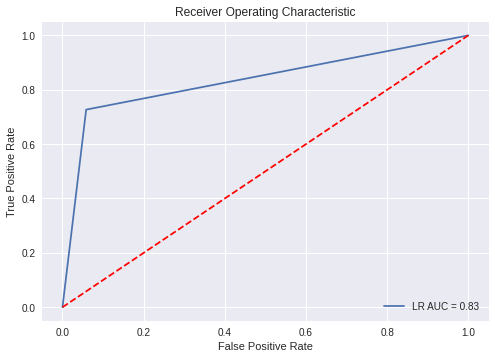

In [ ]:
plt.title("Receiver Operating Characteristic")
# plt.plot(fprXGB, tprXGB, label = "XGB AUC = %0.2f"%roc_aucXGB)
# plt.plot(fprRf, tprRf, label = "RF AUC = %0.2f"%roc_aucRf)
plt.plot(fprLog, tprLog, label = "LR AUC = %0.2f"%roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1],"r--")
# plt.xlim([0,1.1])
# plt.ylim([0,1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

In [ ]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
y_pred = logistic.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     57811
         1.0       0.88      0.73      0.79     32647

    accuracy                           0.86     90458
   macro avg       0.87      0.83      0.85     90458
weighted avg       0.87      0.86      0.86     90458



(54439, 3372, 8913, 23734)

#### *Extra*

In [ ]:
scores_M = [0.8593049336275421, 0.8614312765753646, 0.8633043338450851, 0.8638703166298608, 0.8650804560874074, 0.8667658958323355, 0.8664438189479734, 0.868748398674884, 0.8704119475393517, 0.8562561352754495, 0.8569315624597009, 0.8575069234381396, 0.8596707926248314, 0.8610779304702095, 0.8620066423352135, 0.8559809584822163, 0.8590672831025117, 0.8612405313042131, 0.8709153885678216, 0.8752212334207017, 0.8773131802813864, 0.8748522503144452, 0.8792081259675278, 0.8814407858031373, 0.8772600204148033, 0.8798772955763606, 0.8805558497149585, 0.8593049336275421, 0.8614312765753646, 0.8633043338450851, 0.8638703166298608, 0.8650804560874074, 0.8667658958323355, 0.8664438189479734, 0.868748398674884, 0.8704119475393517, 0.8562561352754495, 0.8569315624597009, 0.8575069234381396, 0.8596707926248314, 0.8610779304702095, 0.8620066423352135, 0.8559809584822163, 0.8590672831025117, 0.8612405313042131, 0.8709153885678216, 0.8752212334207017, 0.8773131802813864, 0.8748522503144452, 0.8792081259675278, 0.8814407858031373, 0.8772600204148033, 0.8798772955763606, 0.8805558497149585]

classWeightNone = scores_M[:27]
classWeightBalanced = scores_M[27:]

# Below is for Class Weight = None
classWeightNone_LearningRate0_01 = classWeightNone[:9]
classWeightNone_LearningRate0_001 = classWeightNone[9:18]
classWeightNone_LearningRate0_1 = classWeightNone[18:]

# Below is for Class Weight = Balanced
classWeightBalanced_LearningRate0_01 = classWeightBalanced[:9]
classWeightBalanced_LearningRate0_001 = classWeightBalanced[9:18]
classWeightBalanced_LearningRate0_1 = classWeightBalanced[18:]

def multiplePlots(mean_test_score, text):
    mean_test_score = np.asarray(mean_test_score)

    parameters = {
    'max_depth':[5,7,15],
    'learning_rate': [0.01,0.001,0.1],
    'class_weight': [None, "balanced"],
    'n_estimators': [100,200,300]
    }

    # Plotting the parameters

    param_xAxis_name = 'n_estimators' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
    param_color_name = 'max_depth' # parameter that you want as the different colored curves

    param_xAxis = parameters[param_xAxis_name]
    param_color = parameters[param_color_name]

    mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

    _, ax = plt.subplots(1,1, figsize=(9,6))

    for i in range(len(param_color)):
        ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

    ax.set_title("XGBClassifier "+text, fontsize=18, fontweight='bold')
    ax.set_xlabel(param_xAxis_name, fontsize=14)
    ax.set_ylabel('CV Avg Score', fontsize=14)
    ax.legend(fontsize=14)
    plt.show()

multiplePlots(classWeightNone_LearningRate0_01, "Class weight: None, Learning rate: 0.01")
multiplePlots(classWeightNone_LearningRate0_001, "Class weight: None, Learning rate: 0.001")
multiplePlots(classWeightNone_LearningRate0_1, "Class weight: None, Learning rate: 0.1")
multiplePlots(classWeightBalanced_LearningRate0_01, "Class weight: Balanced, Learning rate: 0.01")
multiplePlots(classWeightBalanced_LearningRate0_001, "Class weight: Balanced, Learning rate: 0.001")
multiplePlots(classWeightBalanced_LearningRate0_1, "Class weight: Balanced, Learning rate: 0.1")